# Gerador automático de legenda para imagens

- Bernardo Dutra Lemos 
- 2022043949

# Importaçoes

In [1]:
import numpy as np 
import pandas as pd 


import os

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from PIL import Image
from tqdm import tqdm
import pickle
import re


2025-01-28 08:43:47.759687: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 08:43:48.121176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 08:43:48.121283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 08:43:48.181503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 08:43:48.305332: I tensorflow/core/platform/cpu_feature_guar

# Abrindo os dados

In [7]:
#Images folder path
IMAGES_PATH = "Images"
#Caption CSV file path
CAPTIONS_PATH = "captions.txt"

In [8]:
df = pd.read_csv(CAPTIONS_PATH, on_bad_lines='skip', sep = ",")
df = df.dropna()
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## Filtrando as legendas

Nessa seçao filtraremos as legendas, tornando elas minusculas, removendo palavras de tamanho igual a um, pois elas pioram as legendas geradas, alem de adicionar duas palavras especiais de começo e final de sequencia.

Também faremos um dicionario onde as chaves serão os nomes dos arquivos e os valores serão as legendas de cada arquivo(um vetor de strings).

In [9]:
def clean(captions):
    # Convert to lowercase
    captions = captions.lower()
    # Remove numbers, special characters, e o caractere '
    captions = re.sub(r"[^a-z\s]", "", captions)
    # Replace multiple spaces with a single space
    captions = re.sub(r'\s+', ' ', captions).strip()
    # Add start and end sequence tokens
    captions = 'startseq ' + " ".join([word for word in captions.split() if len(word) > 1]) + ' endseq'
    return captions


In [10]:
df["caption"] = df["caption"].apply(clean)
for cap in df["caption"].values[:5]:
    print(cap)

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [11]:
dict_img_to_captions = {}
for i in range(len(df)):
    row = df.iloc[i]
    img = row["image"]
    cap = row["caption"]
    if dict_img_to_captions.get(img) is None:
        dict_img_to_captions[img] = []
    dict_img_to_captions[img].append(cap)

## Tokenizando

Nessa seçao ajustaremos o tokenizer, que será mais util na hora de gerar as entradas para o modelo

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["caption"].values)

In [13]:
for i in df["caption"].values[:2]:
    print(i)
    print(tokenizer.texts_to_sequences([i])[0])
    print()

startseq child in pink dress is climbing up set of stairs in an entry way endseq
[1, 41, 3, 89, 168, 6, 118, 52, 393, 11, 390, 3, 27, 5192, 691, 2]

startseq girl going into wooden building endseq
[1, 18, 312, 63, 192, 116, 2]



# Extraindo features das imagens

Aqui usaremos uma rede pré treinada, chamada de VGG16 para extrair as features de todas as imagens do nosso conjunto de dados.

Também criaremos um novo dicionario, de imagem para vetor de caracteristicas e o salvaremos para evitar computações desnecessarias em execuções posteriores.

Extrair as features de antemão ajuda a economizar muita memoria e tempo na hora de treinar o modelo.

In [14]:
from tensorflow.keras.applications import VGG16

def create_vgg_feature_extractor():
    base_model = VGG16()
    return Model(inputs = base_model.inputs , outputs = base_model.layers[-3].output, name="VGG_FeatureExtractor")

vgg_feature_extractor = create_vgg_feature_extractor()
print(vgg_feature_extractor.summary())

Model: "VGG_FeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

In [15]:
dummy_input = np.random.randn(1, 224, 224, 3)
dummy_output = vgg_feature_extractor.predict(dummy_input)
dummy_output.shape

1/1 [==============================] - 0s 267ms/step


(1, 4096)

In [16]:
def transform_image(image):
    # Redimensiona a imagem para 224x224
    image = image.resize((224, 224))
    # Converte a imagem para um array numpy
    image_array = np.array(image)
    # Adiciona uma dimensão para representar o lote
    image_array = np.expand_dims(image_array, axis=0)
    image_array = tf.keras.applications.vgg16.preprocess_input(image_array)
    return image_array

### Salvando o vetor das imagens

In [17]:
# from concurrent.futures import ThreadPoolExecutor, as_completed

def process_image(img):
    img_path = os.path.join(IMAGES_PATH, img)
    image = Image.open(img_path)
    image = transform_image(image)
    features = vgg_feature_extractor.predict(image, verbose=0)
    return img, features

# vetor_imagens = {}
# for img in tqdm(os.listdir(IMAGES_PATH)):
#     img, feat = process_image(img)
#     vetor_imagens[img] = feat

In [18]:
pickle_file_path = 'model/vetor_imagens.pkl'

# with open(pickle_file_path, 'wb') as f:
#     pickle.dump(vetor_imagens, f)

# print(f'Dicionário salvo como pickle em {pickle_file_path}')

In [19]:
# load features from pickle
with open(pickle_file_path, 'rb') as f:
    vetor_imagens = pickle.load(f)
    print(f'Dicionário carregado de {pickle_file_path}')
vetor_imagens['3607969989_68cc411493.jpg'].shape

Dicionário carregado de model/vetor_imagens.pkl


(1, 4096)

# Modelo

Aqui definimos nosso modelo, que recebera duas entradas, a primeira sendo o vetor de features da imagem, e sua legenda.

In [20]:
embedding_dim = 768 # Dimensao de embedding do BERT
intern_layer = 512
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(i.split()) for i in df["caption"].values])

## Usando embbed do bert

In [ ]:
model_name = "bert-base-uncased" 
hf_tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = TFAutoModel.from_pretrained(model_name)

/home/bdlemos/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initia

In [23]:
# Extrair a matriz de embeddings completa
embedding_layer = hf_model.get_input_embeddings()
embedding_matrix_full = embedding_layer.weight.numpy()

In [24]:
embedding_dim = embedding_matrix_full.shape[1]
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [25]:
c=0
o=0
for word, index in tokenizer.word_index.items():
    if word in hf_tokenizer.vocab:  # Verificar se o token existe no vocabulário do modelo
        c+=1
        hf_index = hf_tokenizer.convert_tokens_to_ids(word)
        embedding_matrix[index] = embedding_matrix_full[hf_index]
    else:
        # Para tokens fora do vocabulário do modelo, usar vetores zerados ou aleatórios
        o+=1
        embedding_matrix[index] = np.random.normal(size=(embedding_dim,))
embedding_matrix.shape
print(f"Sem embed pronto: {o}")
print(f"Com embed pronto: {c}")

Sem embed pronto: 3376
Com embed pronto: 5391


## Definindo o modelo

In [27]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Trainable weights for attention mechanism
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],),
                                 initializer="glorot_uniform", trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)

        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output, alphas

In [28]:
# Modelo 2

caption_input = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], mask_zero=True)(caption_input)

x = LSTM(512)(x)

# Aplicação da camada de atenção (Self-Attention)
# attention_output,_ = AttentionLayer()(x)

x = Dropout(0.5)(x)
x = Dense(intern_layer, activation='relu')(x)
x = Dense(256, activation='relu')(x)

# Construindo o modelo
caption_network = keras.Model(inputs=caption_input, outputs=x)

image_network = keras.Sequential([
    Input(shape=(4096,)),
    #Dense(intern_layer, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    ]
)

combined_network = add([caption_network.output, image_network.output])
dropout = Dropout(0.35)(combined_network)
combined_network = Dense(256, activation='relu')(combined_network)
output = Dense(vocab_size, activation='softmax')(combined_network)

In [29]:
model = Model(inputs=[image_network.input, caption_network.input ], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 768)              6733824   ['input_5[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 512)                  2623488   ['embedding_1[0][0]']         
                                                                                                  
 input_6 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                            

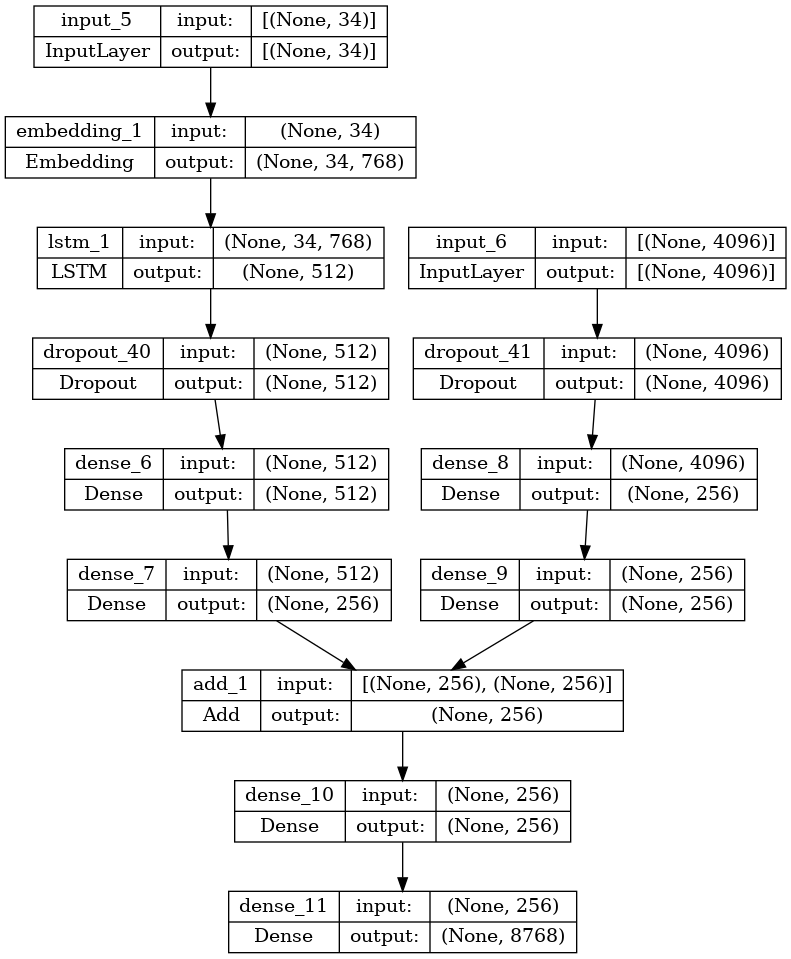

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

Vale ressaltar o uso de dropouts para evitar o overfit da rede e da loss "categorical_crossentropy"

# Criando gerador dos dados

Gerador de dados que prepara batches para o treinamento de um modelo de legendas de imagem.
Ele utiliza as características das imagens (vetor_imagens) e as legendas associadas (img_to_cap).
Para cada imagem e legenda:
- Divide as legendas em sequências de entrada (in_seq) e saídas esperadas (out_seq).
- Padroniza o tamanho das sequências e converte as saídas para one-hot encoding.
- Organiza os dados em batches do tamanho especificado (batch_size) e os retorna.
O gerador é usado em treinamento incremental com grandes volumes de dados.


In [27]:
print(len(vetor_imagens))
print(len(dict_img_to_captions))

8091
8091


In [28]:
print(max_length)
print(vocab_size)

34
8768


In [29]:
def data_generator(img_to_cap, vetor_imagens,batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for i in img_to_cap.keys():
            n += 1
            img = vetor_imagens[i][0]
            for cap in img_to_cap[i]:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [30]:
#Testa o gerador de dados
gerador = data_generator(dict_img_to_captions, vetor_imagens, 32)
X, y = next(gerador)
print(X[0].shape)
print(X[1].shape)
print(y.shape)

(1746, 4096)
(1746, 34)
(1746, 8768)


# Treinamento do modelo

## Treino e teste split

In [33]:
chaves_imagens = list(dict_img_to_captions.keys())

# Divide os dados em 90% treino e 10% teste
n_treino = int(len(chaves_imagens) * 0.9)
chaves_treino = chaves_imagens[:n_treino]
chaves_teste = chaves_imagens[n_treino:]

# Resultados
print(f"Treino: {len(chaves_treino)} imagens")
print(f"Teste: {len(chaves_teste)} imagens")


Treino: 7281 imagens
Teste: 810 imagens


In [34]:
train_dict_img_to_captions = {k: dict_img_to_captions[k] for k in chaves_treino}
test_dict_img_to_captions = {k: dict_img_to_captions[k] for k in chaves_teste}

## Treinamento 

In [33]:
epocas = 30
batche_size = 128
steps = len(train_dict_img_to_captions)//batche_size

generator = data_generator({k: dict_img_to_captions[k] for k in chaves_treino}, vetor_imagens, batche_size)
model.fit(generator, epochs=epocas, steps_per_epoch=steps, verbose=1)
# model.save(f'model/modelo_{epocas+75}.h5')

Epoch 1/30


2025-01-09 14:52:54.517791: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a765500bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-09 14:52:54.517827: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-09 14:52:54.652172: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-09 14:52:54.757825: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 35s 514ms/step - loss: 6.0289
Epoch 2/30
56/56 [==============================] - 28s 507ms/step - loss: 5.0516
Epoch 3/30
56/56 [==============================] - 29s 515ms/step - loss: 4.4510
Epoch 4/30
56/56 [==============================] - 29s 513ms/step - loss: 4.0294
Epoch 5/30
56/56 [==============================] - 29s 514ms/step - loss: 3.7592
Epoch 6/30
56/56 [==============================] - 29s 512ms/step - loss: 3.5605
Epoch 7/30
56/56 [==============================] - 29s 517ms/step - loss: 3.4159
Epoch 8/30
56/56 [==============================] - 28s 509ms/step - loss: 3.2904
Epoch 9/30
56/56 [==============================] - 29s 513ms/step - loss: 3.1859
Epoch 10/30
56/56 [==============================] - 29s 514ms/step - loss: 3.0922
Epoch 11/30
56/56 [==============================] - 29s 512ms/step - loss: 3.0047
Epoch 12/30
56/56 [==============================] - 29s 512ms/step - loss: 2.9241
Epoch 13/30
56/56 [=====

In [35]:
# model.save(f'model/m1_30.h5')
model.load_weights('model/m2_30.h5')

# Gerando legendas

In [36]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        # yhat = yhat.squeeze()
        # yhat = np.random.choice(len(yhat), p=yhat)
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

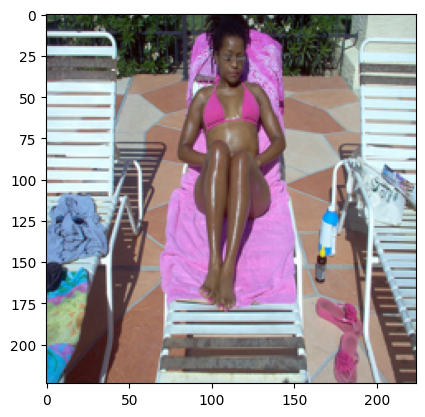

Caption: girl in pink shirt is jumping on trampoline
Real: black woman in pink bikini is sitting on towel on lounge chair
Real: girl with hot pink toe nails and bathing suit is laying on hot pink towel
Real: woman in pink bikini is laying on deck lounge chair that is covered with pink towel
Real: there is very oiled darker woman on pink towel lounging on lawn chair next to her flip flops and suntan lotion
Real: woman in pink is suntanning



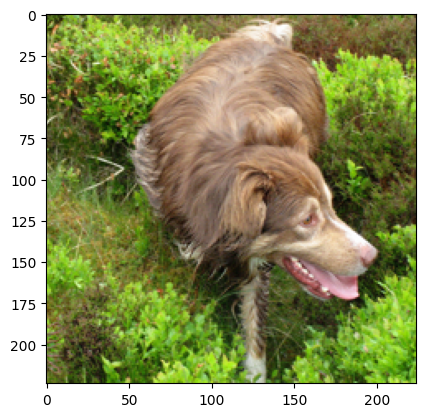

Caption: brown dog is running through the grass
Real: brown dog walks in the under brush
Real: dog pauses in the bushes
Real: dog runs through the long grass
Real: brown dog with mouth open standing amidst greenery
Real: brown longhaired dog in garden



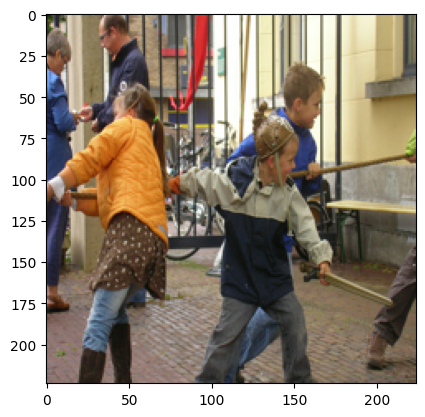

Caption: two men are standing in front of brick building
Real: group of children playing with props
Real: group of kids are sword fighting
Real: children are playing with toy swords in the street
Real: children play fight with swords
Real: some children tugging on rope next to building in city



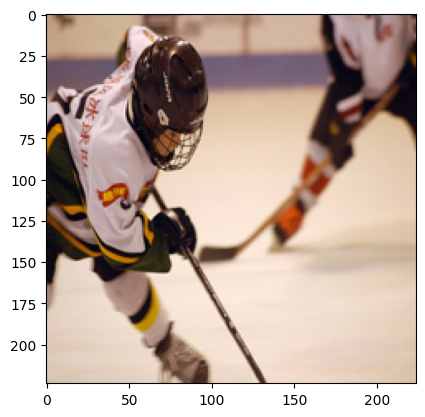

Caption: hockey player in white is sliding down the ice
Real: child is playing ice hockey
Real: young hockey player playing in the ice rink
Real: youth playing hockey
Real: the hockey player is skating on the ice smacking the puck
Real: two people are playing ice hockey



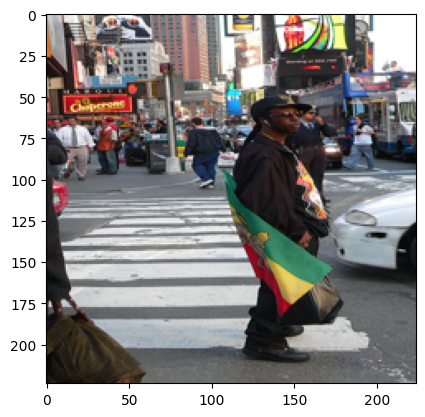

Caption: woman in blue and black is walking down the street
Real: man holding flag is standing on busy sidewalk
Real: man in ball cap stands in crosswalk with flag in crowded city
Real: man stands on crosswalk holding flag
Real: man standing on street with green red and yellow flag wrapped around him and cap on his head
Real: man wrapped in flag stands in city intersection lit billboards in background



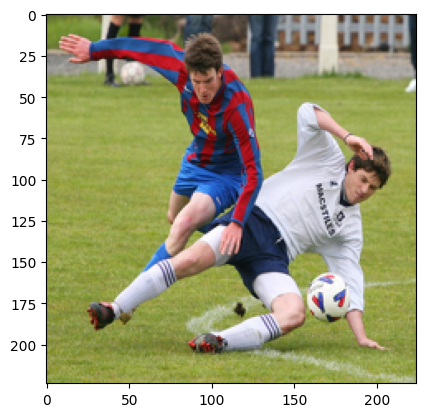

Caption: two soccer players rush to kick the ball
Real: men participate in soccer game
Real: two male soccer players in game action
Real: two men fall as they battle for soccer ball
Real: two opposing footballers play on field
Real: two soccer players playing soccer on field



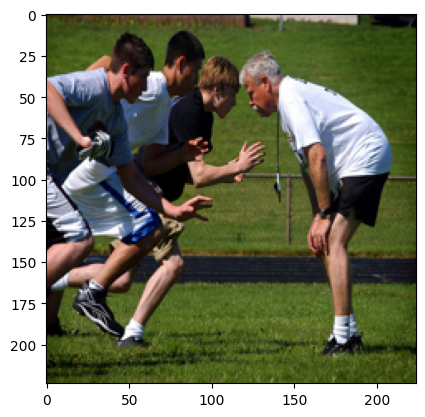

Caption: these men are competing in rugby game
Real: white haired coach is coaching his team of young men while they run towards him
Real: white haired coach stands in front of group of high school age boys running past him
Real: three teenage boys are running towards an older man in white shirt
Real: three young men face an older man with whistle
Real: three young men sprinting past their coach outside



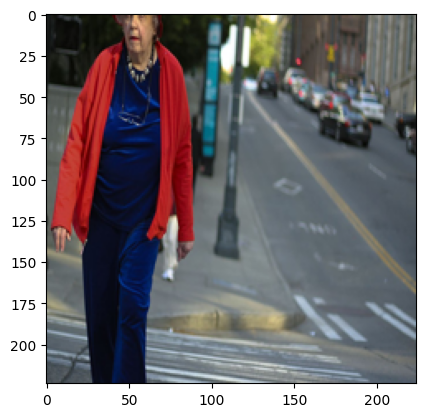

Caption: woman in blue shirt and yellow hat walks down street
Real: an elderly woman crosses the road in city
Real: an elderly woman in red jacket is walking up hilly city street
Real: an elderly woman in blue and red crosses the street in crosswalk
Real: an elderly woman walking uphill crossing the street
Real: old lady crosses the street in the city



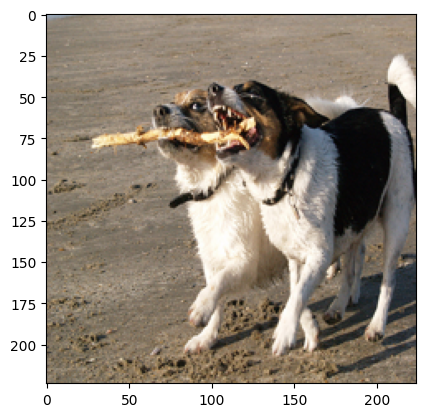

Caption: black and white dog runs on beach
Real: two black and white dogs on the sandy beach fighting over long stick
Real: two dogs carry the same stick in their mouths as they walk on the sand
Real: two dogs holding one stick on beach
Real: two dogs on the beach fight over stick
Real: two dogs on wet sand each biting the same stick



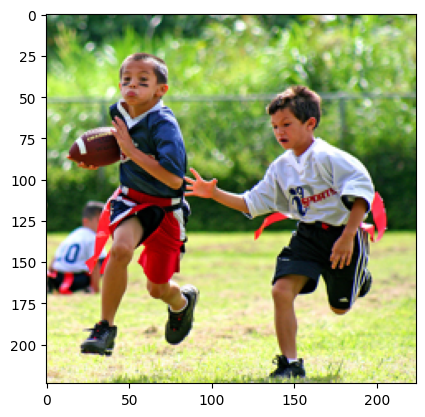

Caption: two men are playing soccer
Real: boys playing tag football run down the field
Real: one kid is chasing another kid who is holding football
Real: one kid is running across field carrying football while another is close behind grabbing for his flags
Real: two children playing tag football
Real: two little boys play football on green grass



In [38]:
import matplotlib.pyplot as plt

for i in chaves_teste[217:227]:
    img = vetor_imagens[i]
    caption = predict_caption(model, img, tokenizer, max_length)
    img_path = os.path.join(IMAGES_PATH, i)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.show()
    print(f"Caption: {caption[9:-7]}")
    for cap in dict_img_to_captions[i]:
        print(f"Real: {cap[9:-7]}")
    print()

## Imagem avulsa

In [39]:
path_to_image = '/home/bdlemos/Faculdade/Semestre_6/NLP/Trabalho/Como-e-a-visao-de-um-gato-Confira-5-curiosidades-aqui-1200x675-1-1024x576.jpg'

_,feat_vector = process_image(path_to_image)
predict_caption(model, feat_vector,tokenizer, max_length)


'startseq dog is jumping off of deck of wood deck endseq'

# BLEU Score

In [38]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(candidate: str, references: list):
    """
    Calcula o BLEU score para uma frase candidata comparada a uma ou mais referências.

    Args:
        candidate (str): Texto gerado automaticamente.
        references (list): Lista de textos de referência.

    Returns:
        float: BLEU score.
    """
    # Suavização para lidar com n-gramas ausentes
    smoothing_function = SmoothingFunction().method1

    # Calcula o BLEU score
    bleu_score = sentence_bleu(references, candidate, smoothing_function=smoothing_function, weights=(1, 0, 0, 0))
    return bleu_score

In [39]:
scores = []
for i in tqdm(chaves_teste):
    img = vetor_imagens[i]
    caption = predict_caption(model, img, tokenizer, max_length)
    references = [cap for cap in dict_img_to_captions[i]]
    bleu = calculate_bleu(caption, references)
    scores.append(bleu)

print(f"BLEU médio: {np.mean(scores)}")

100%|██████████| 810/810 [07:59<00:00,  1.69it/s]

BLEU médio: 0.886898224080552


# Replicabilidade dummie

In [40]:
print(vocab_size, max_length)

8768 34


In [42]:
embedding_dim_dummie = 768 # Dimensao de embedding do BERT
intern_layer_dummie = 512
vocab_size_dummie = 8768
max_length_dummie = 34

In [43]:
# Modelo 2

caption_input = Input(shape=(max_length_dummie,))
x = Embedding(vocab_size_dummie, embedding_dim_dummie, mask_zero=True)(caption_input)

x = LSTM(512)(x)

# Aplicação da camada de atenção (Self-Attention)
# attention_output,_ = AttentionLayer()(x)

x = Dropout(0.5)(x)
x = Dense(intern_layer, activation='relu')(x)
x = Dense(256, activation='relu')(x)

# Construindo o modelo
caption_network = keras.Model(inputs=caption_input, outputs=x)

image_network = keras.Sequential([
    Input(shape=(4096,)),
    #Dense(intern_layer, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    ]
)

combined_network = add([caption_network.output, image_network.output])
dropout = Dropout(0.35)(combined_network)
combined_network = Dense(256, activation='relu')(combined_network)
output = Dense(vocab_size_dummie, activation='softmax')(combined_network)

In [44]:
model_dummie = Model(inputs=[image_network.input, caption_network.input ], outputs=output)
model_dummie.compile(loss='categorical_crossentropy', optimizer='adam')

In [49]:
input_image = np.random.randn(100, 4096)
input_caption = np.random.randint(0, 8768, size=(100, 34))
output_data = np.zeros((100, 8768), dtype=int)
for i in range(100):
    value = np.random.randint(0, 8768)
    output_data[i, value] = 1 

print(input_image.shape)
print(input_caption.shape)
print(output_data.shape)

(100, 4096)
(100, 34)
(100, 8768)


In [50]:
model_dummie.fit([input_image, input_caption], output_data, epochs=10, batch_size=32)

Epoch 1/10
4/4 [==============================] - 4s 215ms/step - loss: 9.0828
Epoch 2/10
4/4 [==============================] - 1s 218ms/step - loss: 8.1368
Epoch 3/10
4/4 [==============================] - 1s 206ms/step - loss: 5.6939
Epoch 4/10
4/4 [==============================] - 1s 222ms/step - loss: 3.5949
Epoch 5/10
4/4 [==============================] - 1s 220ms/step - loss: 2.3399
Epoch 6/10
4/4 [==============================] - 1s 215ms/step - loss: 1.5207
Epoch 7/10
4/4 [==============================] - 1s 203ms/step - loss: 0.7371
Epoch 8/10
4/4 [==============================] - 1s 212ms/step - loss: 0.2697
Epoch 9/10
4/4 [==============================] - 1s 213ms/step - loss: 0.0605
Epoch 10/10
4/4 [==============================] - 1s 221ms/step - loss: 0.0251
